In [1]:
import pandas as pd

In [95]:
df = pd.read_csv("../data/BaselineED_bench.csv")
gen =pd.read_csv("../data/GenED_bench.csv")

paper_cols = ['log', 'fitness_heu', 'precision_heu',
           'fscore_heu', 'size_heu', 'cfc_heu', 'fitness_ilp', 'precision_ilp', 'fscore_ilp',
           'size_ilp','cfc_ilp', 'fitness_imf', 'precision_imf', 'fscore_imf', 'size_imf', 'cfc_imf']

df= df[paper_cols]

print(gen.shape, df.shape)
#print(gen.columns == df.columns)

(432, 19) (17, 16)


In [96]:
df['source']='Real'
gen['source']='Generated'
both_df = pd.concat([df, gen])
print(both_df.shape)
both_df.head()

(449, 20)


,log,fitness_heu,precision_heu,fscore_heu,size_heu,cfc_heu,fitness_ilp,precision_ilp,fscore_ilp,size_ilp,cfc_ilp,fitness_imf,precision_imf,fscore_imf,size_imf,cfc_imf,source,pnsize_heu,pnsize_ilp,pnsize_imf
0,BPIC16wm_p,0.999900,1.000000,0.999950,5.0,2.0,0.999950,1.000000,0.999975,4.0,1.0,0.999900,1.000000,0.999950,5.0,2.0,Real,NaN,NaN,NaN
1,BPIC13op,0.990133,0.962056,0.975893,12.0,7.0,0.999930,0.906565,0.950961,10.0,3.0,0.851320,0.906565,0.878074,17.0,8.0,Real,NaN,NaN,NaN
2,BPIC13cp,0.989977,0.868430,0.925229,14.0,8.0,0.999955,0.792380,0.884148,20.0,6.0,0.990413,0.947021,0.968231,15.0,9.0,Real,NaN,NaN,NaN
3,RTFMP,0.847745,0.991357,0.913944,47.0,22.0,0.999979,0.589212,0.741509,43.0,14.0,0.878360,0.780275,0.826417,41.0,20.0,Real,NaN,NaN,NaN
4,SEPSIS,0.650269,0.702381,0.675321,64.0,29.0,0.999987,0.198110,0.330704,96.0,44.0,0.960534,0.443997,0.607283,43.0,23.0,Real,NaN,NaN,NaN


In [97]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(both_df.drop(['log','source'], axis=1))
imp_df = imp_mean.transform(both_df.drop(['log','source'], axis=1))
imp_df = pd.DataFrame(imp_df, columns = both_df.columns[2:])
print("Before:", len(both_df.loc[:, both_df.isna().any()].columns), "columns in", len(both_df.loc[:, both_df.isna().any()]), 'rows')
print("After:", len(imp_df.loc[:, imp_df.isna().any()].columns))

Before: 18 columns in 449 rows
After: 0


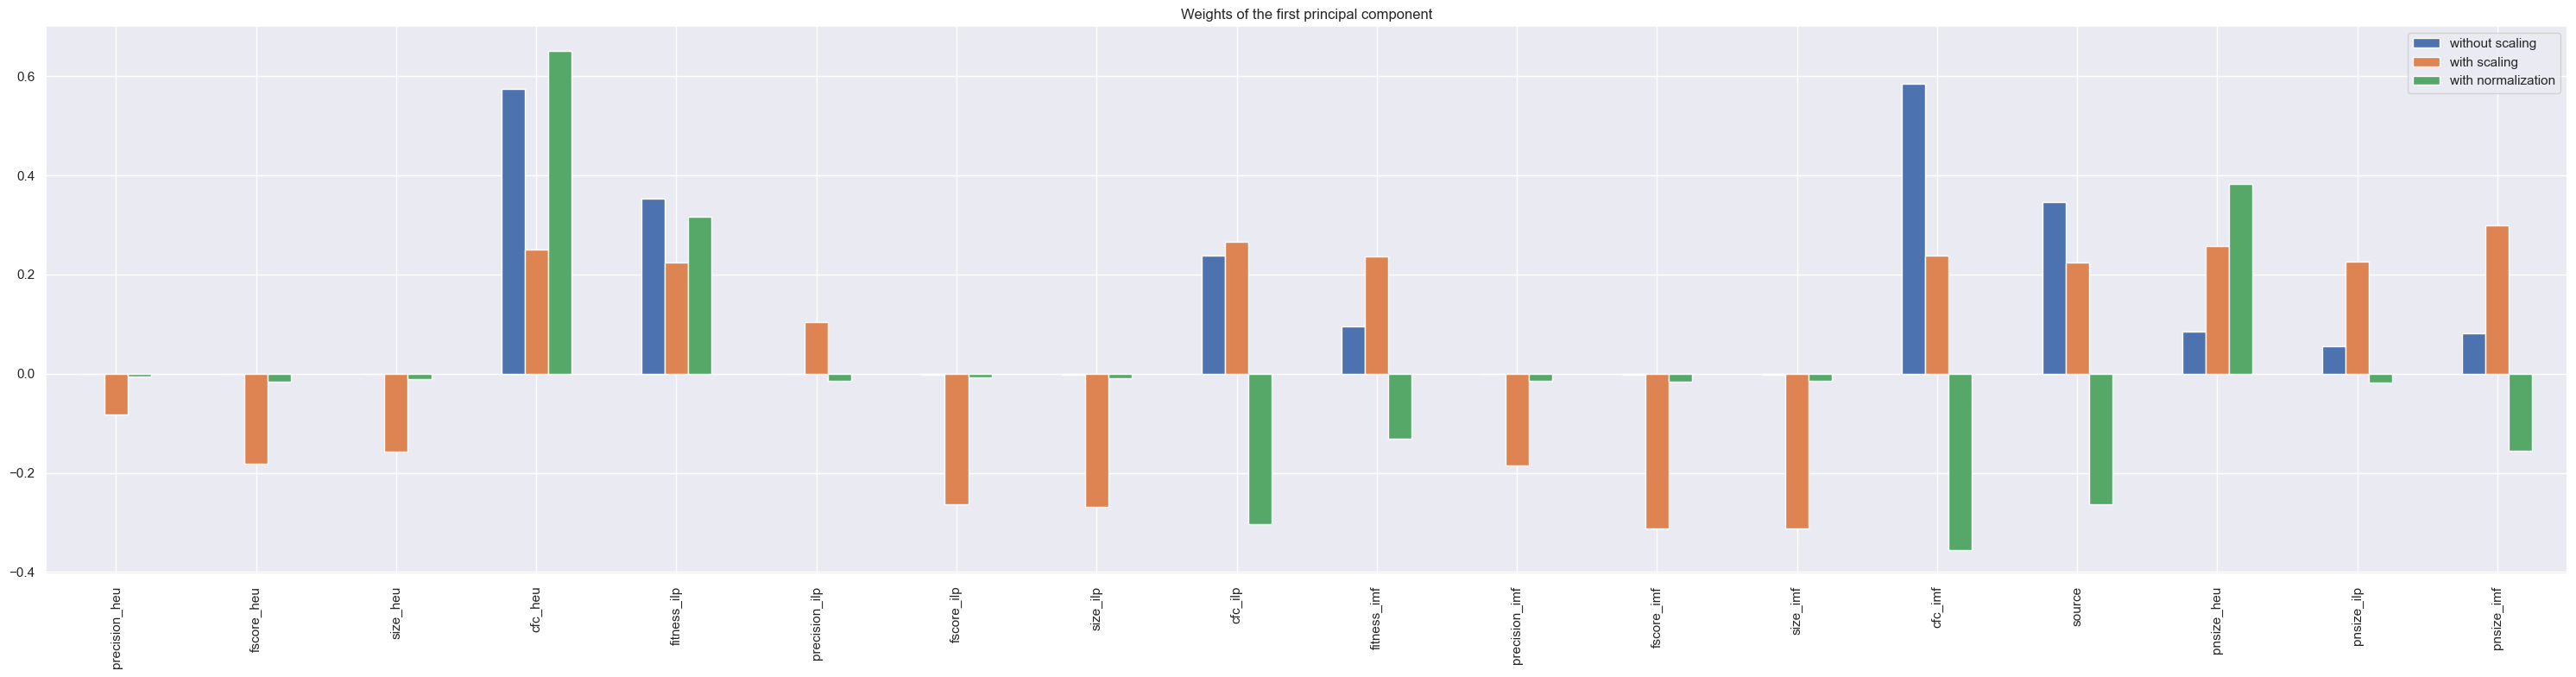

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X = imp_df
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X)
normed_X = Normalizer(norm="l2").fit_transform(X)


import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
norm_pca = PCA(n_components=2).fit(normed_X)


X_train_transformed = pca.transform(X)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)
X_train_norm_transformed = norm_pca.transform(normed_X)


first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component["with normalization"] = norm_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(30, 8)
)

_ = plt.tight_layout()

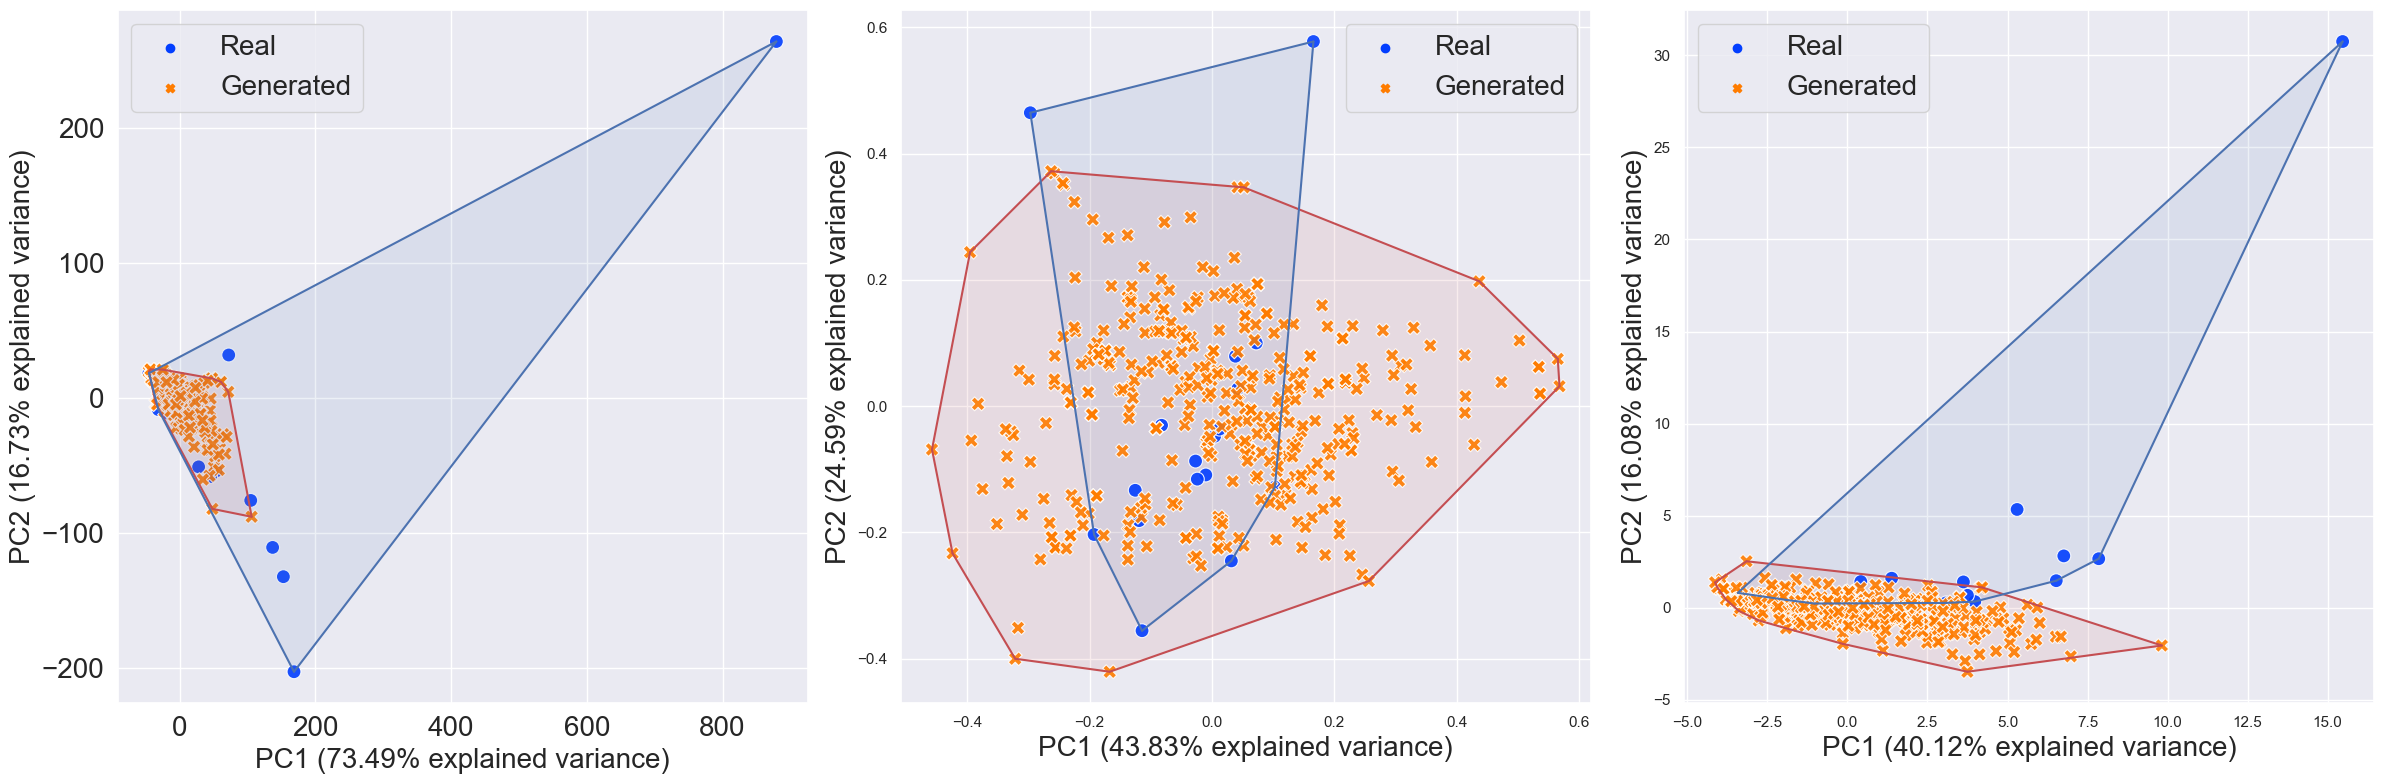

In [99]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

FONT_SIZE=20
def plot_convex_hull(numbers, ax, style, color):
    hull = ConvexHull(numbers)
    for simplex in hull.simplices:
        ax.plot(numbers[simplex, 0], numbers[simplex, 1], style)
    ax.fill(numbers[hull.vertices,0], numbers[hull.vertices,1], color, alpha=0.1)

pca = PCA(n_components=2)

# Normalizer: By default, L2 normalization is applied to each observation so the that the values in a row have a unit norm. 
    # Unit norm with L2 means that if each element were squared and summed, the total would equal 1. 
    #Normalizer does transform all the features to values between -1 and 1. 
#norm_data = Normalizer(norm="l2").fit_transform(df.drop(["log"], axis=1))
norm_data = Normalizer(norm="l2").fit_transform(X)

#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. 
    #Unit variance means dividing all the values by the standard deviation.
scaler = StandardScaler()
sca_data = scaler.fit_transform(X)
#norm_data = Normalizer(norm="l2").fit_transform(norm_data)

sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24, 8), dpi=100)
#fig, ax1 = plt.subplots(figsize=(8, 8), dpi=100)

X_new = pca.fit_transform(X)
df_pca = pd.DataFrame(X_new, columns=["PC1", "PC2"])
df_pca['source']=both_df['source'].to_numpy()
numbers_gen = df_pca[df_pca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca[df_pca['source'] == 'Real'][['PC1', 'PC2']].to_numpy()

sns.scatterplot(ax=ax1, data=df_pca, x="PC1", y="PC2", palette="bright", hue='source',
                alpha=0.9, s=100, style="source")
plot_convex_hull(numbers_gen, ax1, 'r-', 'r')
plot_convex_hull(numbers_real, ax1, 'b-', 'b')

ax1.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax1.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax1.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax1.tick_params(axis='both', which='minor', labelsize=FONT_SIZE)
ax1.legend(prop={'size': FONT_SIZE})

X_new_norm = pca.fit_transform(norm_data)
df_pca_norm = pd.DataFrame(X_new_norm, columns=["PC1", "PC2"])
df_pca_norm['source']=both_df['source'].to_numpy()
numbers_gen = df_pca_norm[df_pca_norm['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_norm[df_pca_norm['source'] == 'Real'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax2, 'r-', 'r')
plot_convex_hull(numbers_real, ax2, 'b-', 'b')

sns.scatterplot(ax=ax2, data=df_pca_norm, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax2.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax2.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax2.legend(prop={'size': FONT_SIZE})

X_new_sca = pca.fit_transform(sca_data)
df_pca_sca = pd.DataFrame(X_new_sca, columns=["PC1", "PC2"])
df_pca_sca['source']=both_df['source'].to_numpy()
numbers_gen = df_pca_sca[df_pca_sca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_sca[df_pca_sca['source'] == 'Real'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax3, 'r-', 'r')
plot_convex_hull(numbers_real, ax3, 'b-', 'b')
sns.scatterplot(ax=ax3, data=df_pca_sca, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax3.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax3.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE)
ax3.legend(prop={'size': FONT_SIZE})

plt.tight_layout()
#plt.savefig("../output/plots/pca_GenED_baselineED.png", transparent=True)
# plt.show()
# plt.close()

../output/plots/pca_BaselineED_GenED.png


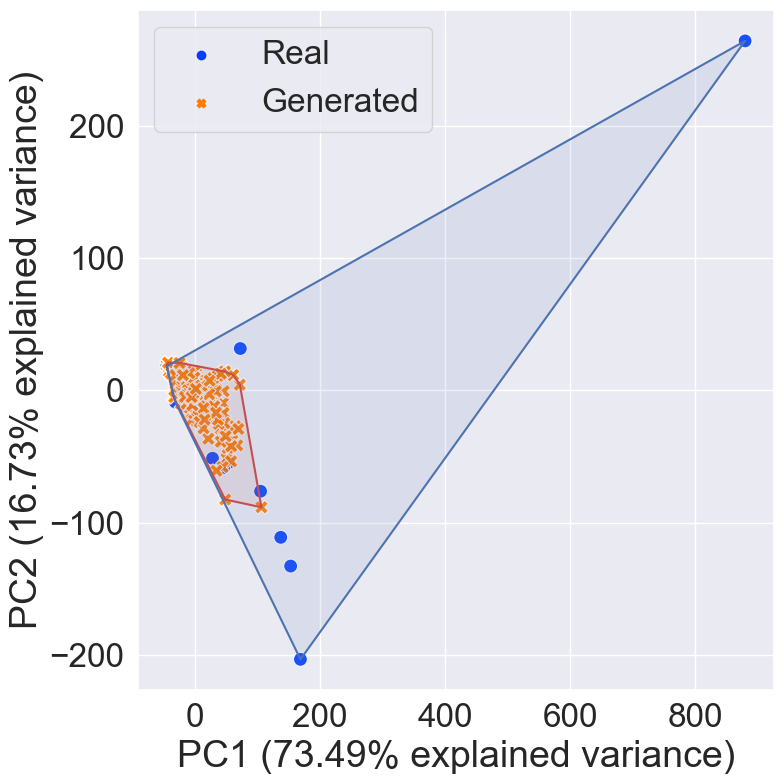

In [100]:
FONTSIZE=24
sns.set_theme()
fig, ax1 = plt.subplots(1,1,figsize=(8, 8))

X_new = pca.fit_transform(X)
df_pca = pd.DataFrame(X_new, columns=["PC1", "PC2"])
df_pca['source']=both_df['source'].to_numpy()
numbers_gen = df_pca[df_pca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca[df_pca['source'] == 'Real'][['PC1', 'PC2']].to_numpy()

sns.scatterplot(ax=ax1, data=df_pca, x="PC1", y="PC2", palette="bright", hue='source',
                alpha=0.9, s=100, style="source")
plot_convex_hull(numbers_gen, ax1, 'r-', 'r')
plot_convex_hull(numbers_real, ax1, 'b-', 'b')

ax1.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)", fontsize=FONT_SIZE+7)
ax1.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)", fontsize=FONT_SIZE+7)
ax1.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax1.tick_params(axis='both', which='minor', labelsize=FONT_SIZE)
ax1.legend(prop={'size': FONT_SIZE})

plt.yticks(fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
#plt.xticks(rotation=-30)

plt.tight_layout()
output_path = f"../output/plots/pca_BaselineED_GenED.png"
print(output_path)
plt.savefig(output_path, dpi=300, transparent=True)

In [101]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gedi.plotter import FeaturesPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SUCCESS: Saved , plot_type='boxplot' plot in ../output/plots/boxplots_GenED_bench_3fts_432gEL_of379.jpg
SUCCESS: Saved , plot_type='boxplot' plot in ../output/plots/boxplots_GenED_bench_3fts_432gEL_of341.jpg
SUCCESS: Saved , plot_type='boxplot' plot in ../output/plots/boxplots_GenED_bench_3fts_432gEL_of419.jpg


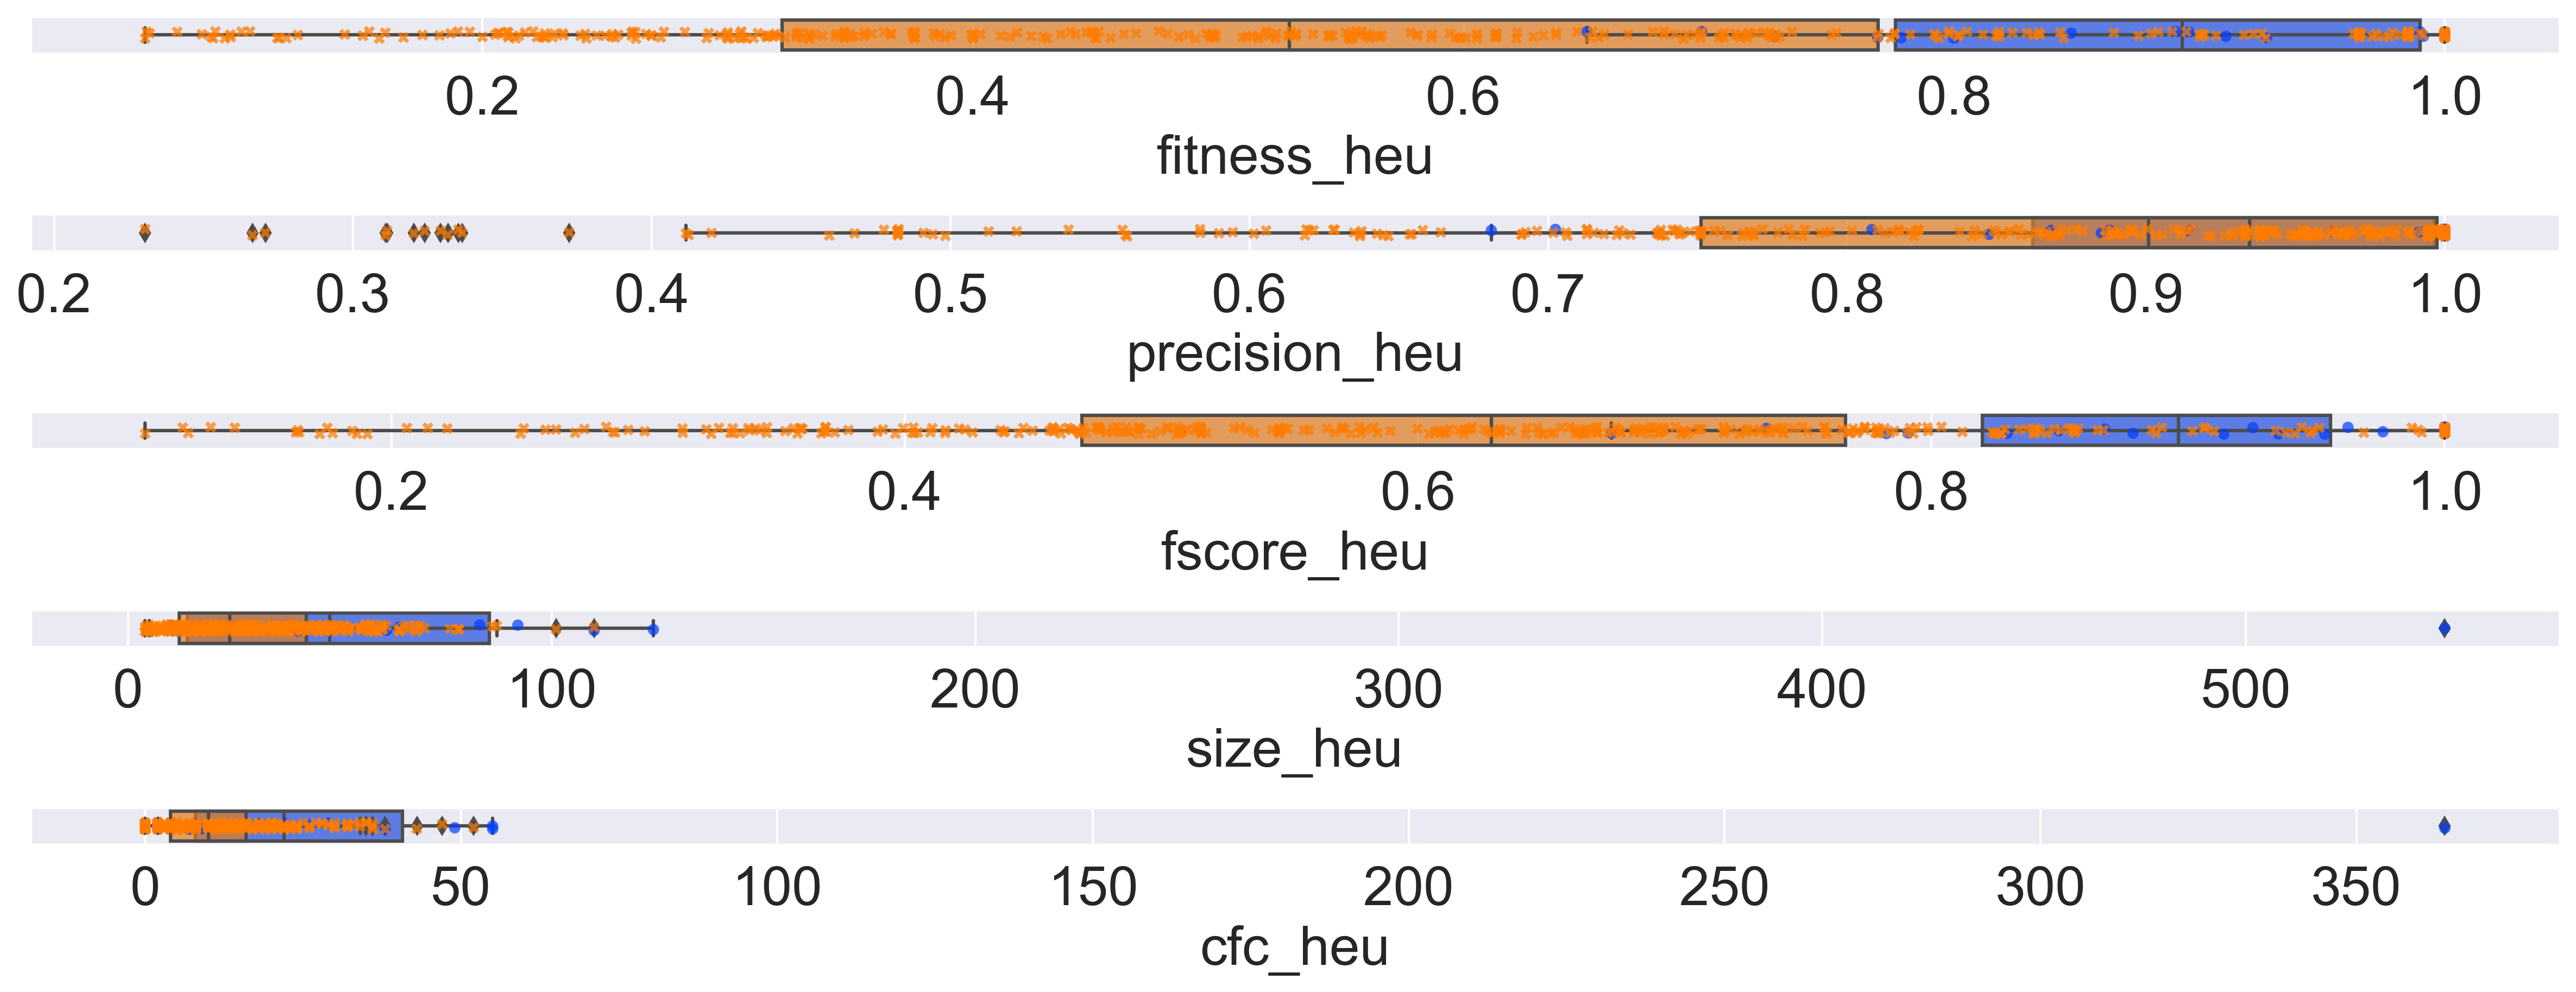

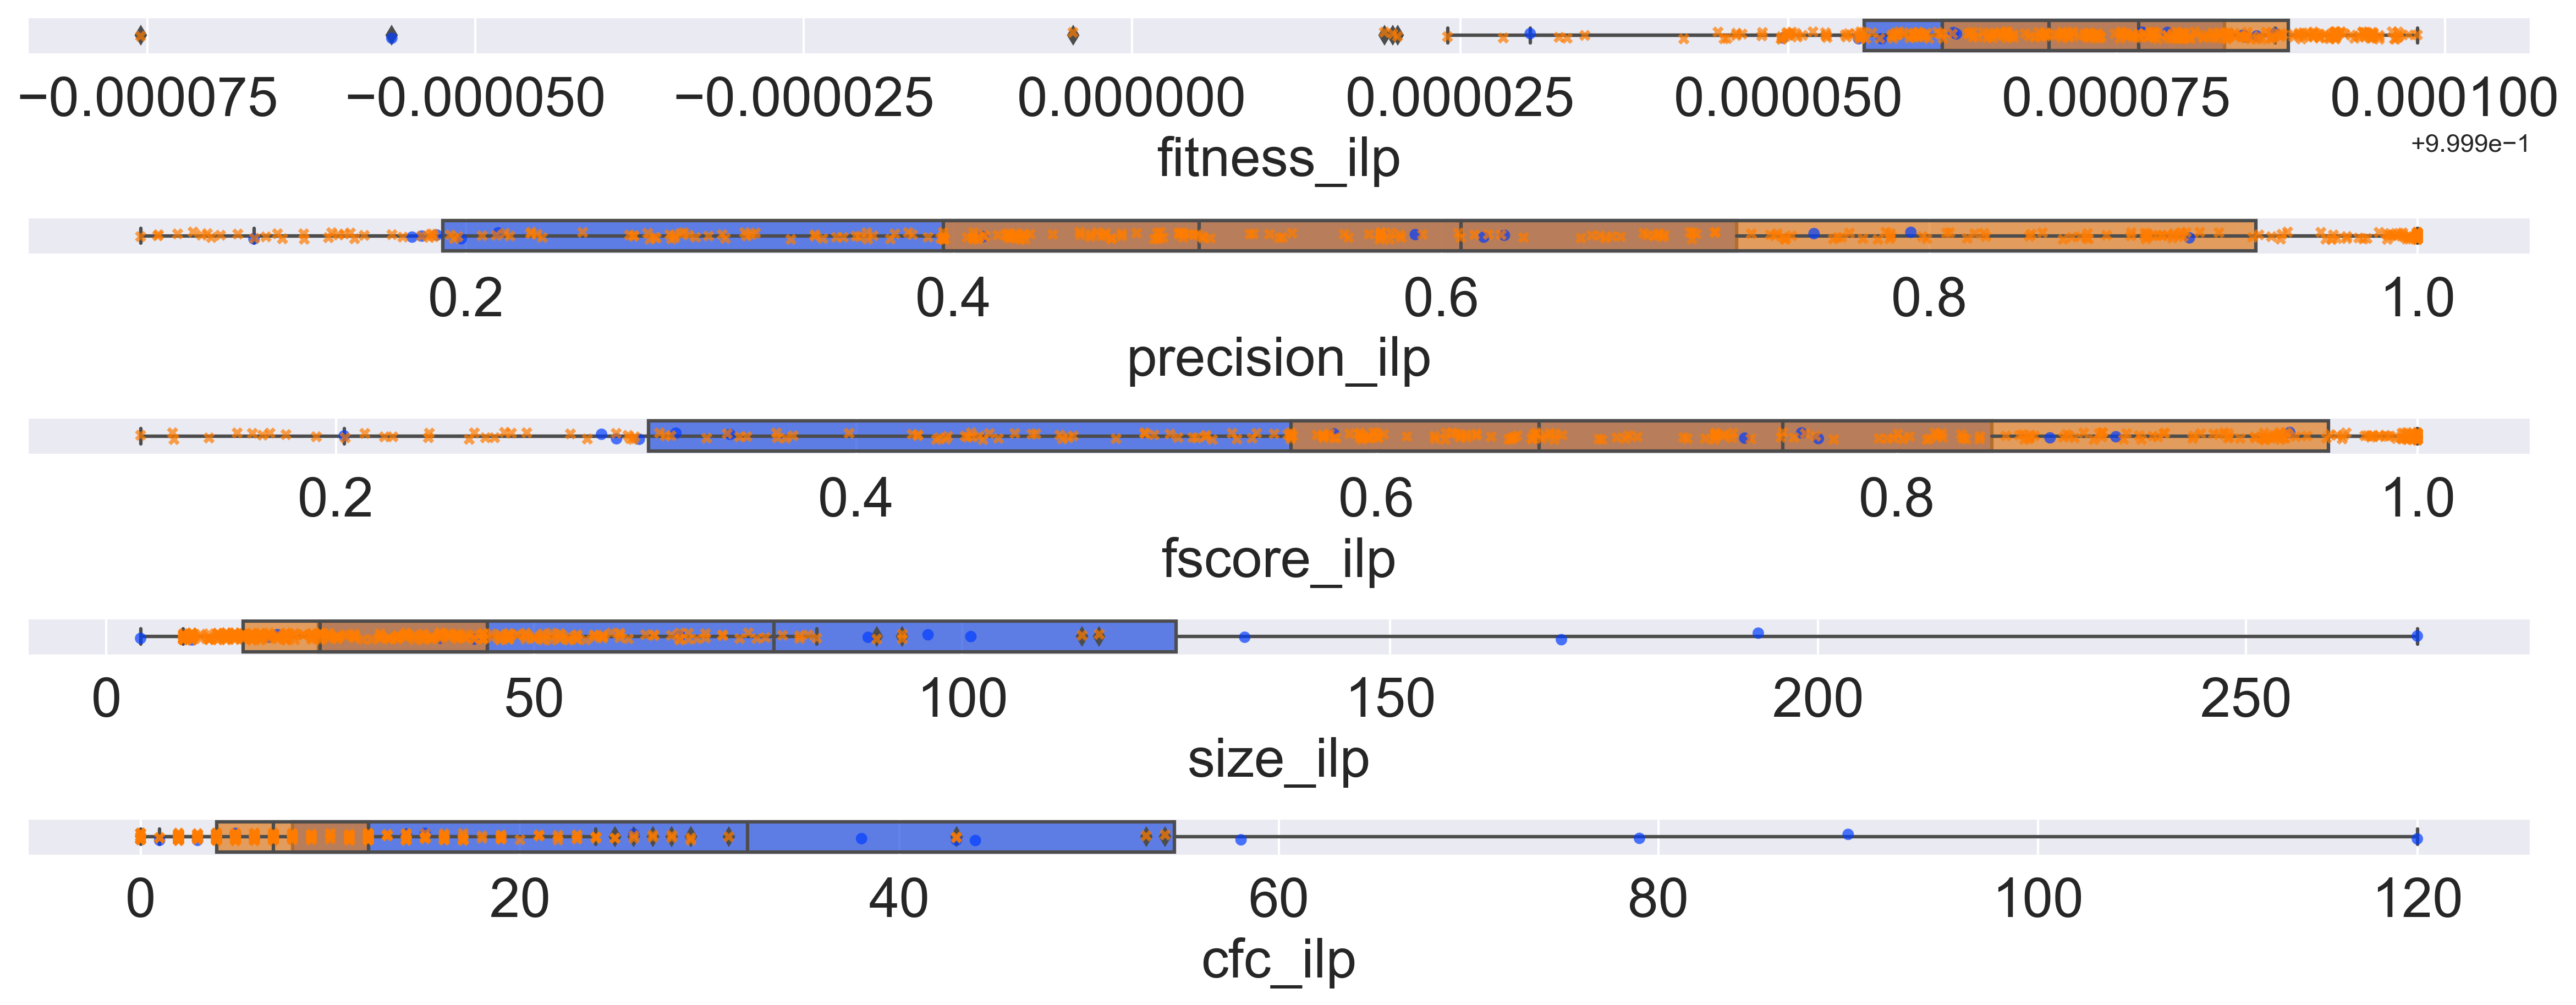

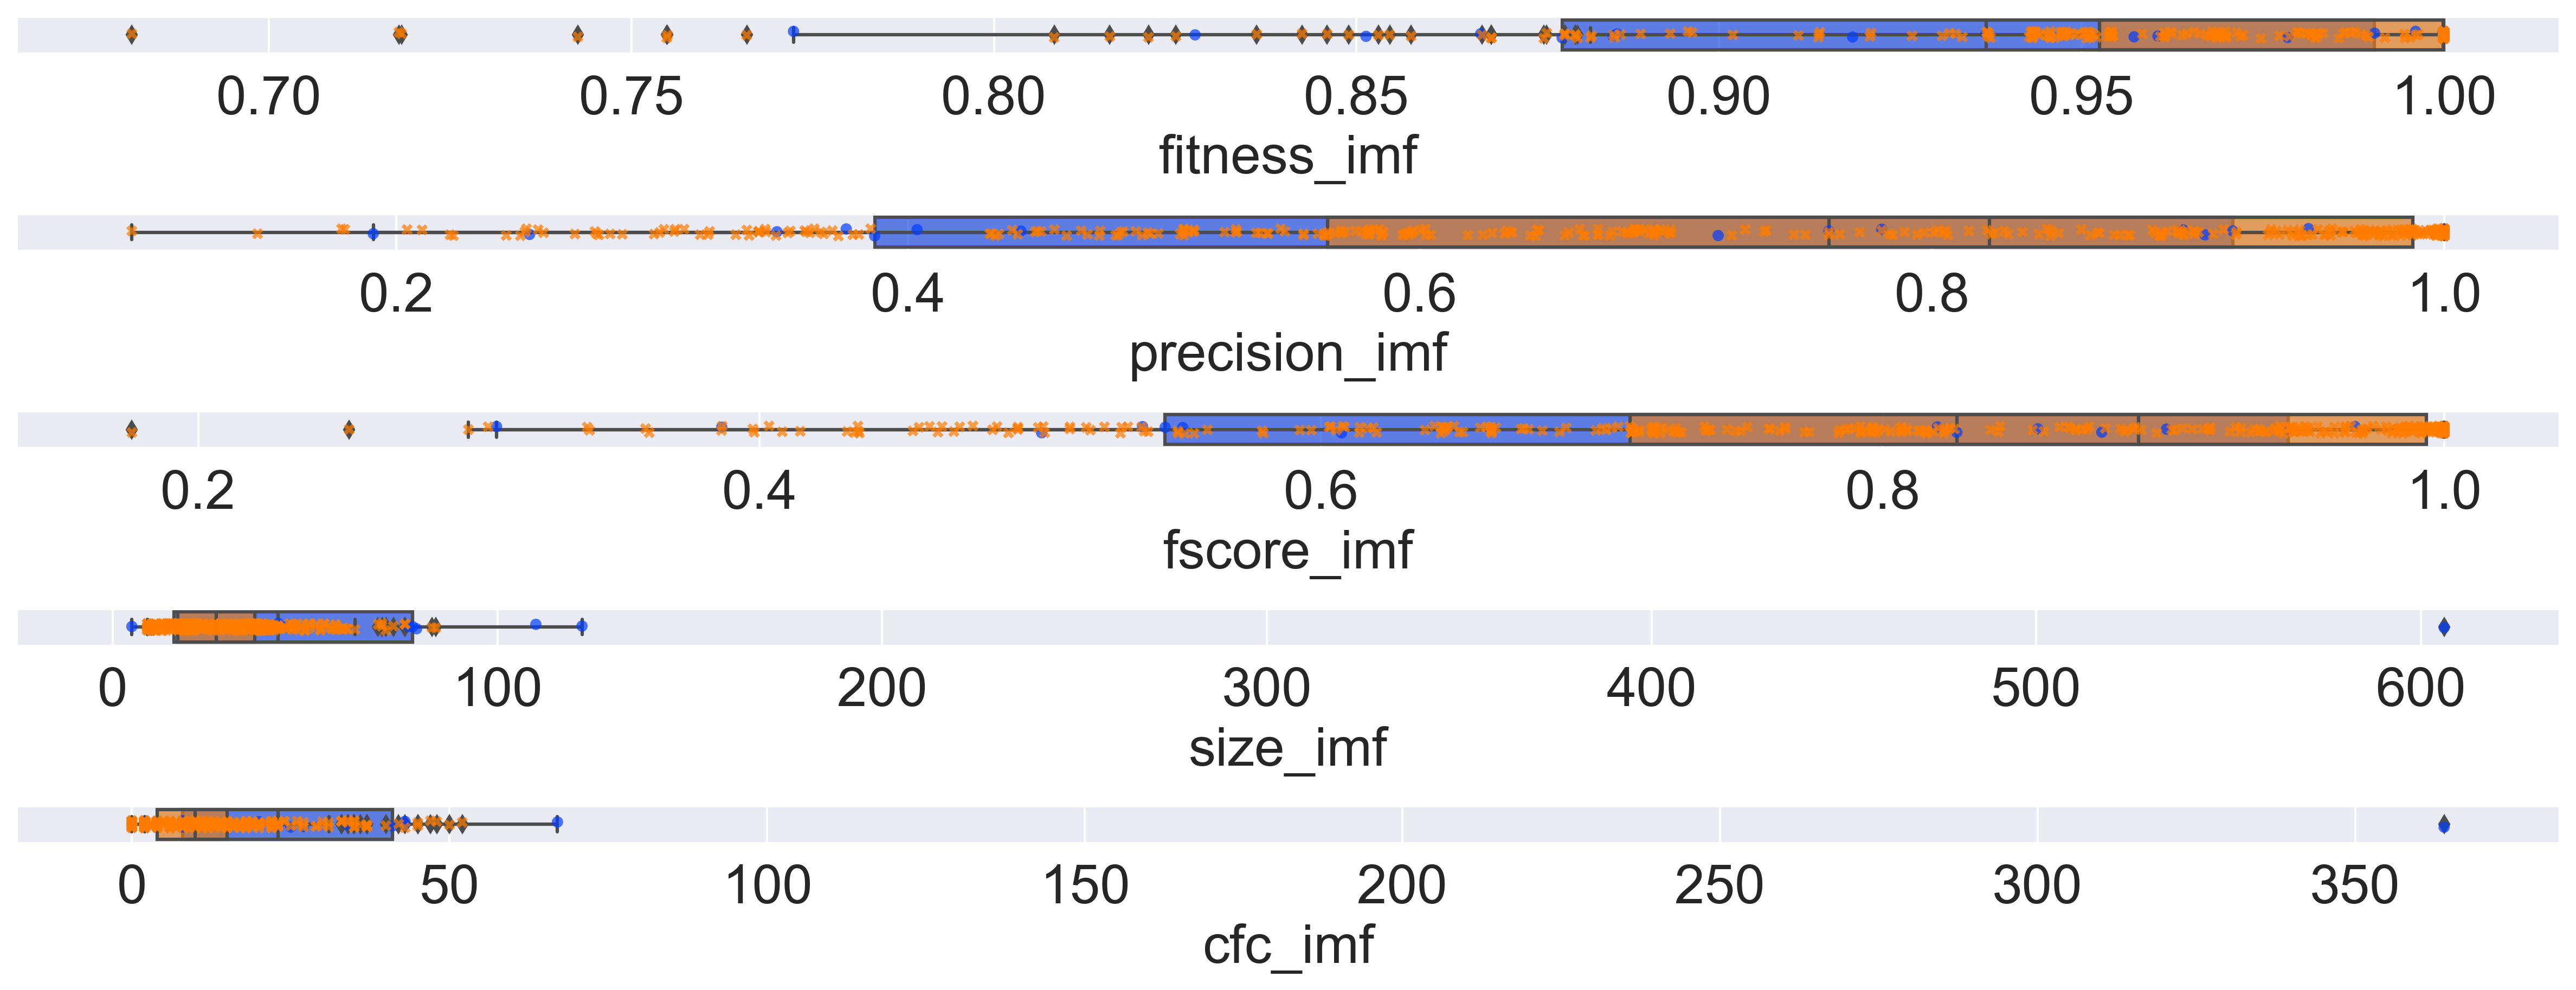

In [115]:
model_params = {"output_path":"../output/plots", "input_path":"../data/GenED_bench.csv",
                "real_eventlog_path": "../data/BaselineED_bench.csv",
                "plot_type":"boxplot", "font_size":24}
generated = gen.drop(['source'], axis=1)

miners = ['heu', 'ilp', 'imf']
for miner in miners:
    metrics = ['fitness', 'precision', 'fscore', 'size', 'cfc']
    metrics = [(x+'_'+miner) for x in metrics]
    generated_heu = generated[metrics]
    FeaturesPlotter( generated_heu, model_params)
